# 01 — EDA de SportsMOT 🏀⚽🏐

En este notebook vamos a:

- Cargar la estructura de **SportsMOT** en formato MOTChallenge.
- Leer `seqinfo.ini` de cada secuencia (FPS, resolución, longitud).
- Usar los archivos `splits_txt/*.txt` para:
  - Contar cuántos videos hay por split (train/val/test).
  - Ver cuántos son de **basketball / football / volleyball**.
- Leer `gt/gt.txt` para:
  - Calcular el número de **tracks** (jugadores) por video.
  - Calcular el **número promedio de jugadores por frame**.
- Visualizar:
  - Histogramas de longitud de secuencias.
  - Distribución de jugadores por frame.

## 1.  Imports y configuración de rutas 🧩


In [ ]:
from pathlib import Path
import configparser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

sns.set(style="whitegrid")

# Detectar raíz del proyecto y carpeta de datos
NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent          # carpeta que contiene notebooks/ y data/
SPORTSMOT_ROOT = PROJECT_ROOT / "data"      # <-- aquí está lo que muestras en el pantallazo

SPLITS_DIR = SPORTSMOT_ROOT / "splits_txt"
DATASET_ROOT = SPORTSMOT_ROOT / "dataset"   # contiene train/val/test

VERBOSE = False  #  # cambiar a True en caso de querer ver las rutas

if VERBOSE:
    print("NOTEBOOK_DIR:", NOTEBOOK_DIR)
    print("PROJECT_ROOT:", PROJECT_ROOT)
    print("SPORTSMOT_ROOT:", SPORTSMOT_ROOT)
    print("SPLITS_DIR:", SPLITS_DIR)
    print("DATASET_ROOT:", DATASET_ROOT)


## 2. Cargar splits 📄

Leemos los archivos splits_txt/*.txt, que listan los nombres de las secuencias en cada split y en cada deporte.

El dataset utilizado es un ejemplo, por lo que solo contiene tres videos, los tres etiquetados como train.

In [30]:
def read_split_file(name, path: Path):
    """Lee un archivo .txt de splits y devuelve un set de nombres de secuencia."""
    if not path.exists():
        print(f"⚠ WARNING: split file no encontrado: {name}")
        return set()
    with path.open("r") as f:
        lines = [ln.strip() for ln in f.readlines()]
    return {ln for ln in lines if ln and not ln.startswith("#")}


split_files = {
    "train": SPLITS_DIR / "train.txt",
    "val": SPLITS_DIR / "val.txt",
    "test": SPLITS_DIR / "test.txt",
}

sport_files = {
    "basketball": SPLITS_DIR / "basketball.txt",
    "football": SPLITS_DIR / "football.txt",
    "volleyball": SPLITS_DIR / "volleyball.txt",
}

splits = {name: read_split_file(name, path) for name, path in split_files.items()}
sports = {name: read_split_file(name, path) for name, path in sport_files.items()}

print("Resumen de splits:")
for split, vids in splits.items():
    print(f"  {split:5s}: {len(vids)} secuencias")

print("\nResumen por deporte:")
for sport, vids in sports.items():
    print(f"  {sport:10s}: {len(vids)} secuencias")


⚠ WARNING: split file no encontrado: val
⚠ WARNING: split file no encontrado: test
Resumen de splits:
  train: 3 secuencias
  val  : 0 secuencias
  test : 0 secuencias

Resumen por deporte:
  basketball: 1 secuencias
  football  : 1 secuencias
  volleyball: 1 secuencias


## 3. Función para leer seqinfo.ini de una secuencia 📋

En formato MOTChallenge, seqinfo.ini contiene, entre otras, información de FPS, tamaño de imagen y número de frames. 

In [16]:
def parse_seqinfo(seq_dir: Path) -> dict:
    ini_path = seq_dir / "seqinfo.ini"
    if not ini_path.exists():
        raise FileNotFoundError(f"No se encontró seqinfo.ini en {seq_dir}")

    config = configparser.ConfigParser()
    config.read(ini_path)

    seq = config["Sequence"]

    name = seq.get("name", seq_dir.name)
    im_width = int(seq.get("imWidth"))
    im_height = int(seq.get("imHeight"))
    seq_length = int(seq.get("seqLength"))
    fps = float(seq.get("frameRate"))
    img_dir = seq.get("imDir", "img1")

    return {
        "sequence": name,
        "im_width": im_width,
        "im_height": im_height,
        "seq_length": seq_length,
        "fps": fps,
        "img_dir": img_dir,
        "path": str(seq_dir),
    }


def build_sequences_df(dataset_root: Path, splits: dict, sports: dict) -> pd.DataFrame:
    rows = []
    for split_name, seq_names in splits.items():
        split_dir = dataset_root / split_name
        for seq_name in seq_names:
            seq_dir = split_dir / seq_name
            if not seq_dir.exists():
                print(f"⚠ WARNING: no existe {seq_dir}")
                continue

            info = parse_seqinfo(seq_dir)

            if seq_name in sports["basketball"]:
                sport = "basketball"
            elif seq_name in sports["football"]:
                sport = "football"
            elif seq_name in sports["volleyball"]:
                sport = "volleyball"
            else:
                sport = "unknown"

            rows.append(
                {
                    "sequence": info["sequence"],
                    "split": split_name,
                    "sport": sport,
                    "fps": info["fps"],
                    "im_width": info["im_width"],
                    "im_height": info["im_height"],
                    "seq_length": info["seq_length"],
                    "path": info["path"],
                }
            )

    return pd.DataFrame(rows)


seq_df = build_sequences_df(DATASET_ROOT, splits, sports)
seq_df.head()


,sequence,split,sport,fps,im_width,im_height,seq_length,path
0,v_ApPxnw_Jffg_c016,train,volleyball,25.0,1280,720,352,/Users/davidgiraldovalencia/Documents/Universi...
1,v_-6Os86HzwCs_c009,train,basketball,25.0,1280,720,500,/Users/davidgiraldovalencia/Documents/Universi...
2,v_gQNyhv8y0QY_c013,train,football,25.0,1280,720,875,/Users/davidgiraldovalencia/Documents/Universi...


## 4. Construir tabla de secuencias (meta a nivel video) 🧮

Creamos un DataFrame con una fila por secuencia, incluyendo: split, deporte, fps, tamaño, longitud.

In [17]:
def build_sequences_df(dataset_root: Path, splits: dict, sports: dict) -> pd.DataFrame:
    rows = []
    for split_name, seq_names in splits.items():
        split_dir = dataset_root / split_name
        for seq_name in seq_names:
            seq_dir = split_dir / seq_name
            if not seq_dir.exists():
                print(f"⚠ WARNING: no existe {seq_dir}")
                continue

            info = parse_seqinfo(seq_dir)

            # Detectamos deporte por pertenencia en los sets
            if seq_name in sports["basketball"]:
                sport = "basketball"
            elif seq_name in sports["football"]:
                sport = "football"
            elif seq_name in sports["volleyball"]:
                sport = "volleyball"
            else:
                sport = "unknown"

            rows.append(
                {
                    "sequence": info["sequence"],
                    "split": split_name,
                    "sport": sport,
                    "fps": info["fps"],
                    "im_width": info["im_width"],
                    "im_height": info["im_height"],
                    "seq_length": info["seq_length"],
                    "path": info["path"],
                }
            )

    return pd.DataFrame(rows)


seq_df = build_sequences_df(DATASET_ROOT, splits, sports)
seq_df.head()


,sequence,split,sport,fps,im_width,im_height,seq_length,path
0,v_ApPxnw_Jffg_c016,train,volleyball,25.0,1280,720,352,/Users/davidgiraldovalencia/Documents/Universi...
1,v_-6Os86HzwCs_c009,train,basketball,25.0,1280,720,500,/Users/davidgiraldovalencia/Documents/Universi...
2,v_gQNyhv8y0QY_c013,train,football,25.0,1280,720,875,/Users/davidgiraldovalencia/Documents/Universi...


## 5. Vista rápida de la secuencia (animación) 🎞️
Muestra de frames consecutivos usando una animación ligera.

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def animate_frames(frames, interval=50):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')

    im = ax.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))

    def update(frame_idx):
        im.set_array(cv2.cvtColor(frames[frame_idx], cv2.COLOR_BGR2RGB))
        ax.set_title(f'Frame {frame_idx}')
        return [im]

    anim = FuncAnimation(fig, update, frames=len(frames), blit=True, interval=interval)
    print('Generando animación de video...')
    html_video = HTML(anim.to_jshtml())
    plt.close(fig)
    return html_video

# Tomar primeros 50 frames (o menos si la secuencia es corta)
frame_paths = sorted(list(img_dir.glob('*.jpg'))) or sorted(list((img_dir).glob('*.png')))
frame_paths = frame_paths[:50]
if not frame_paths:
    raise FileNotFoundError(f'No se encontraron frames en {img_dir}')

frames = []
for p in frame_paths:
    img_bgr = cv2.imread(str(p))
    if img_bgr is not None:
        frames.append(img_bgr)

if not frames:
    raise RuntimeError('No se pudieron cargar los frames para animación')

video_animation = animate_frames(frames, interval=60)
video_animation



## 6. Estadísticas globales de las secuencias 📊

In [18]:
print("Número total de secuencias:", len(seq_df))
print("\nConteo por split:")
print(seq_df["split"].value_counts())

print("\nConteo por deporte:")
print(seq_df["sport"].value_counts())

print("\nResoluciones únicas (ancho x alto):")
print(seq_df.groupby(["im_width", "im_height"]).size())


Número total de secuencias: 3

Conteo por split:
split
train    3
Name: count, dtype: int64

Conteo por deporte:
sport
volleyball    1
basketball    1
football      1
Name: count, dtype: int64

Resoluciones únicas (ancho x alto):
im_width  im_height
1280      720          3
dtype: int64


Veamos algunas distribuciones:

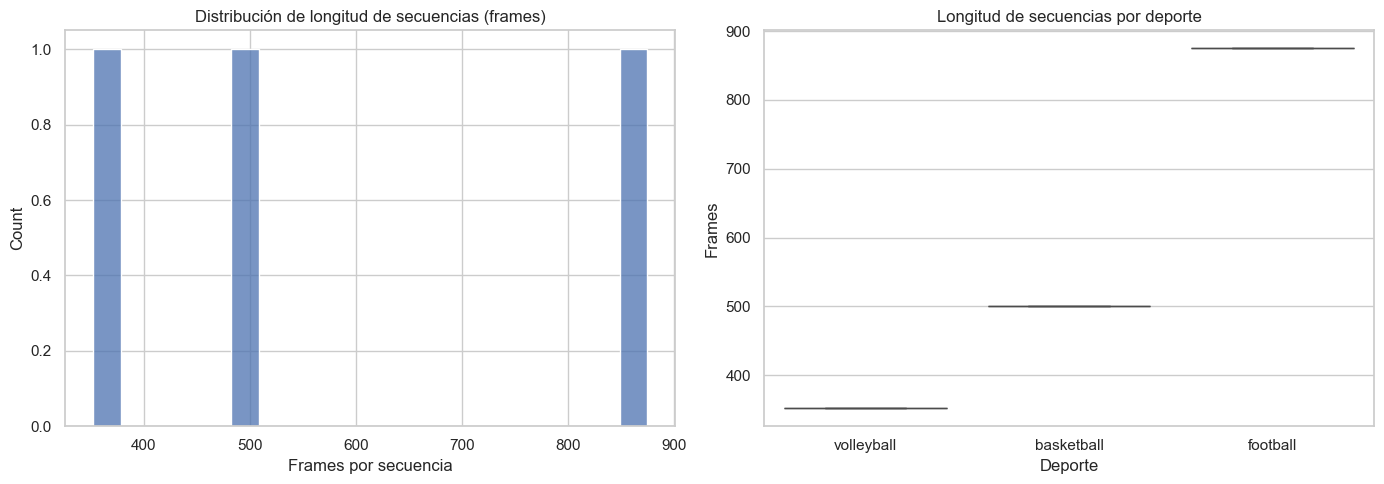

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(seq_df["seq_length"], bins=20, ax=axes[0])
axes[0].set_title("Distribución de longitud de secuencias (frames)")
axes[0].set_xlabel("Frames por secuencia")

sns.boxplot(data=seq_df, x="sport", y="seq_length", ax=axes[1])
axes[1].set_title("Longitud de secuencias por deporte")
axes[1].set_xlabel("Deporte")
axes[1].set_ylabel("Frames")

plt.tight_layout()
plt.show()


## 7. Leer anotaciones gt/gt.txt y contar tracks / jugadores por frame 🎯

Según el formato MOT17, cada fila de gt.txt es: frame, id, x, y, w, h, conf, class, visibility.

In [ ]:
def load_gt(seq_dir: Path) -> pd.DataFrame:
    """
    Carga gt/gt.txt de una secuencia y devuelve un DataFrame con columnas:
    frame, id, x, y, w, h, conf, cls, vis
    """
    gt_path = seq_dir / "gt" / "gt.txt"
    if not gt_path.exists():
        raise FileNotFoundError(f"No se encontró gt.txt en {gt_path}")

    cols = ["frame", "id", "x", "y", "w", "h", "conf", "cls", "vis"]
    df = pd.read_csv(gt_path, header=None, names=cols)
    return df


# Ejemplo con una secuencia de train
example_seq_name = seq_df[seq_df["split"] == "train"]["sequence"].iloc[0]
example_seq_path = Path(seq_df[seq_df["sequence"] == example_seq_name]["path"].iloc[0])

print("Ejemplo de secuencia:", example_seq_name)
gt_example = load_gt(example_seq_path)
gt_example.head()

Ejemplo de secuencia: v_ApPxnw_Jffg_c016


,frame,id,x,y,w,h,conf,cls,vis
0,1,0,696,442,52,123,1,1,1
1,1,1,1020,352,65,110,1,1,1
2,1,2,609,411,35,115,1,1,1
3,1,3,444,371,57,142,1,1,1
4,1,4,416,354,56,151,1,1,1


## 8. Estadísticas de anotaciones por secuencia 📈

Vamos a construir un DataFrame con:

- n_frames_gt: número de frames anotados

- n_tracks: número de IDs únicos

- players_per_frame_mean y players_per_frame_std

In [21]:
def compute_annotation_stats_for_sequence(seq_row: pd.Series) -> dict:
    seq_dir = Path(seq_row["path"])
    gt = load_gt(seq_dir)

    n_frames_gt = gt["frame"].nunique()
    n_tracks = gt["id"].nunique()

    players_per_frame = gt.groupby("frame")["id"].nunique()
    players_per_frame_mean = players_per_frame.mean()
    players_per_frame_std = players_per_frame.std()

    return {
        "sequence": seq_row["sequence"],
        "split": seq_row["split"],
        "sport": seq_row["sport"],
        "n_frames_gt": n_frames_gt,
        "n_tracks": n_tracks,
        "players_per_frame_mean": players_per_frame_mean,
        "players_per_frame_std": players_per_frame_std,
    }


ann_stats_rows = [compute_annotation_stats_for_sequence(row) for _, row in seq_df.iterrows()]
ann_df = pd.DataFrame(ann_stats_rows)

ann_df.head()


,sequence,split,sport,n_frames_gt,n_tracks,players_per_frame_mean,players_per_frame_std
0,v_ApPxnw_Jffg_c016,train,volleyball,352,12,11.142045,1.135917
1,v_-6Os86HzwCs_c009,train,basketball,500,10,9.982000,0.133084
2,v_gQNyhv8y0QY_c013,train,football,875,20,12.065143,2.816527



## 9. Analizar densidad de jugadores y número de tracks 📊

Resumen global de tracks:
        n_tracks  players_per_frame_mean
count   3.000000                3.000000
mean   14.000000               11.063063
std     5.291503                1.043815
min    10.000000                9.982000
25%    11.000000               10.562023
50%    12.000000               11.142045
75%    16.000000               11.603594
max    20.000000               12.065143


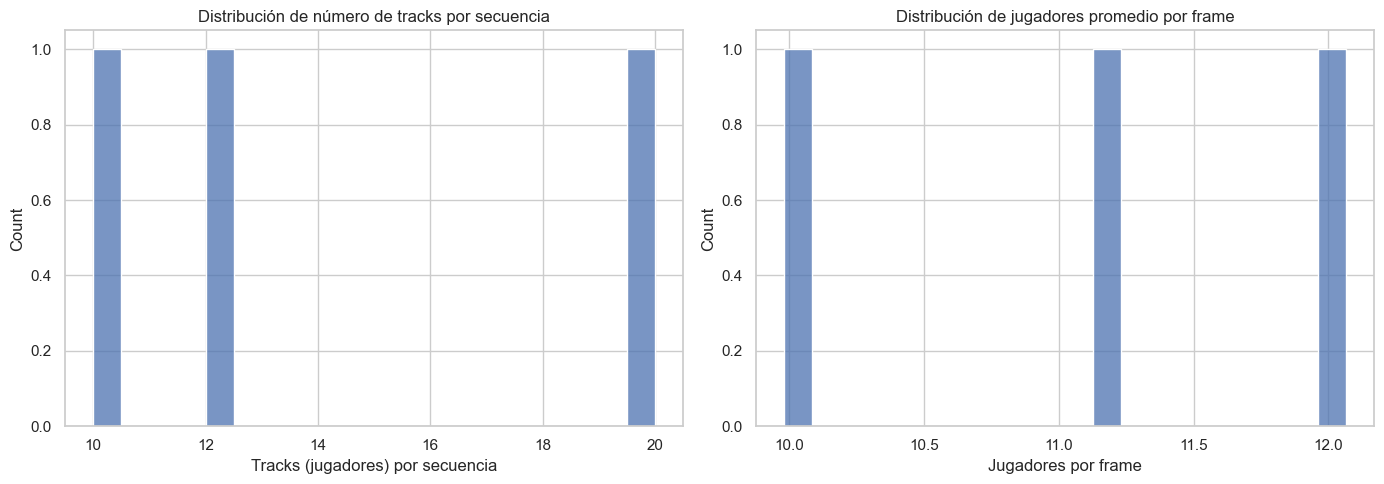

In [22]:
print("Resumen global de tracks:")
print(ann_df[["n_tracks", "players_per_frame_mean"]].describe())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(ann_df["n_tracks"], bins=20, ax=axes[0])
axes[0].set_title("Distribución de número de tracks por secuencia")
axes[0].set_xlabel("Tracks (jugadores) por secuencia")

sns.histplot(ann_df["players_per_frame_mean"], bins=20, ax=axes[1])
axes[1].set_title("Distribución de jugadores promedio por frame")
axes[1].set_xlabel("Jugadores por frame")

plt.tight_layout()
plt.show()


Y por deporte:

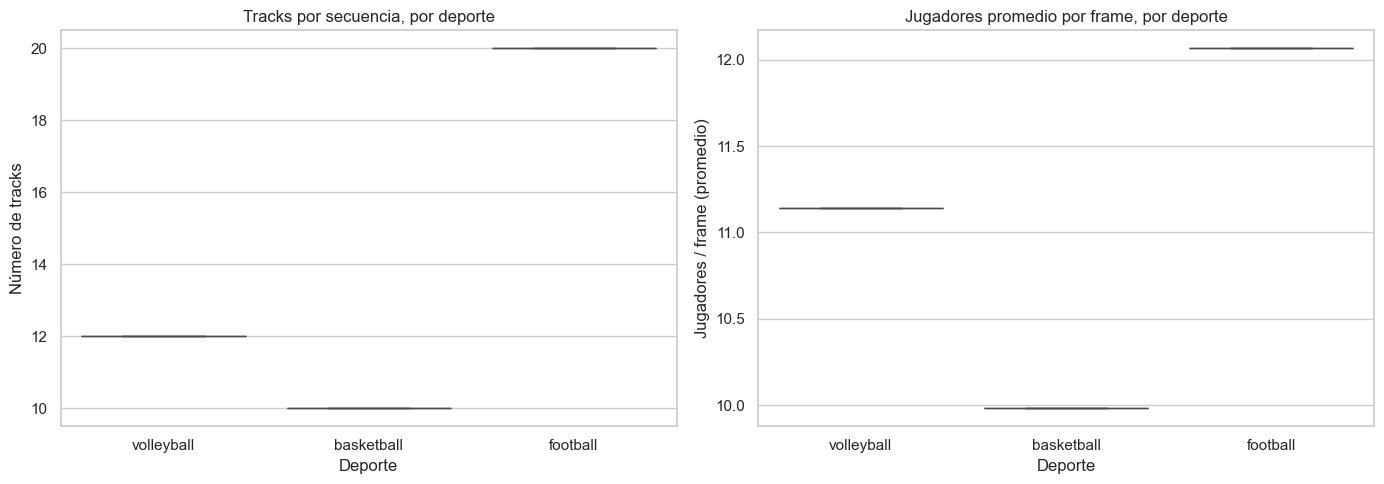

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=ann_df, x="sport", y="n_tracks", ax=axes[0])
axes[0].set_title("Tracks por secuencia, por deporte")
axes[0].set_xlabel("Deporte")
axes[0].set_ylabel("Número de tracks")

sns.boxplot(data=ann_df, x="sport", y="players_per_frame_mean", ax=axes[1])
axes[1].set_title("Jugadores promedio por frame, por deporte")
axes[1].set_xlabel("Deporte")
axes[1].set_ylabel("Jugadores / frame (promedio)")

plt.tight_layout()
plt.show()


9. Visualizar algunos frames con anotaciones 🎥

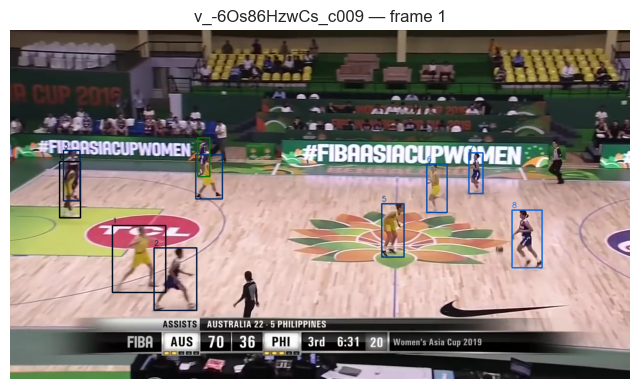

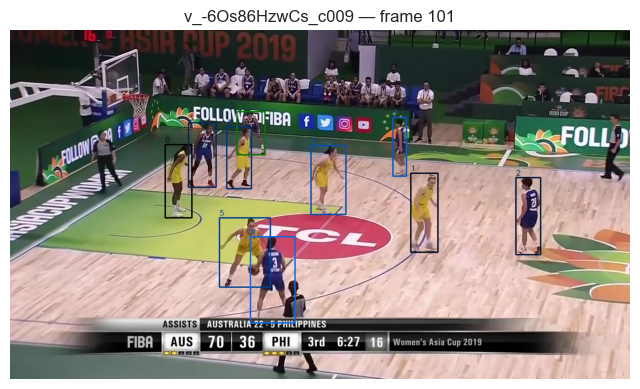

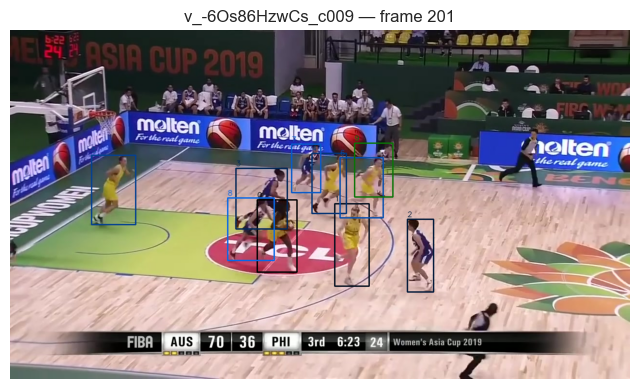

In [27]:
def visualize_sequence_frames_with_boxes(seq_row, num_frames=3, step=50):
    seq_dir = Path(seq_row["path"])
    img_dir = seq_dir / "img1"
    gt = load_gt(seq_dir)

    # Elegimos algunos frames espaciados
    max_frame = gt["frame"].max()
    chosen_frames = list(range(1, min(max_frame, num_frames * step) + 1, step))

    for fr in chosen_frames:
        img_path = img_dir / f"{fr:06d}.jpg"
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        gt_fr = gt[gt["frame"] == fr]

        for _, row in gt_fr.iterrows():
            x, y, w, h = row["x"], row["y"], row["w"], row["h"]
            track_id = int(row["id"])
            # Color sencillo derivado del id
            color = (hash(track_id) % 255, (hash(track_id*13) % 255), (hash(track_id*29) % 255))
            color = tuple(int(c) for c in color)

            cv2.rectangle(img, (int(x), int(y)), (int(x + w), int(y + h)), color, 2)
            cv2.putText(img, str(track_id), (int(x), int(y) - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(f"{seq_row['sequence']} — frame {fr}")
        plt.axis("off")
        plt.show()

# Ejemplo: visualizamos una secuencia de basketball de train
example_basketball = seq_df[(seq_df["sport"] == "basketball") & (seq_df["split"] == "train")].iloc[0]
visualize_sequence_frames_with_boxes(example_basketball, num_frames=3, step=100)
